<h1> The SVD Ellipsoid <span class="tocSkip"></span></h1>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import numpy as np

Consider the rectangular matrix $X$ with singular value decomposition (SVD)
$$X = U \Sigma V^T = U \begin{pmatrix} 4 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{pmatrix} V^T.$$

Then we have singular values $\sigma_1 = 4, \sigma_2 = 2,$ and $\sigma_3 = 1$. Now, as we iteratively decrease $\sigma_3$ to be smaller and smaller, we can see how the ellipsoid representing our approximation collapses from 3D to 2D.

Click on discrete points on the slider to have $\sigma_3$ adjust to that value. 

<IPython.core.display.Javascript object>


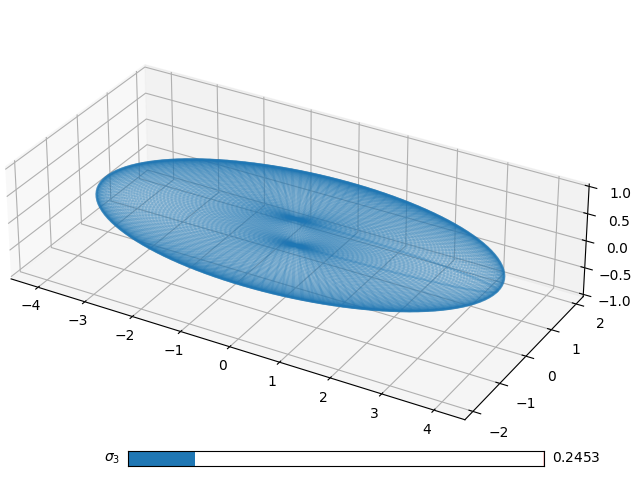

In [2]:
%matplotlib notebook
plt.close('all')
fig = plt.figure()
# Make room for the slider
plt.subplots_adjust(bottom = 0.25)                
ax = fig.add_subplot(111, projection='3d')

# Angle of the projection in the xy-plane
phi = np.linspace(0, 2*np.pi, 256).reshape(256, 1)
# Angle from the polar axis, i.e. the polar angle
theta = np.linspace(0, np.pi, 256).reshape(-1, 256)
# Ellipsoid formulas in spherical coordinate system
x = 4*np.sin(theta)*np.cos(phi)
y = 2*np.sin(theta)*np.sin(phi)

# The parametrized function to be plotted
def z(r_z, theta, phi):
    return r_z*np.cos(theta)

# Define initial parameter
r_z_init = 1

# Draw ellipsoid
ax.plot_wireframe(x, y, z(r_z_init, theta, phi), rstride = 2, cstride = 2, alpha = 0.2)         
ax.set_box_aspect((4, 2, 1))
# Adjust formatting
fig.subplots_adjust(left = 0, right = .9, bottom = -1.5, top = 2.5)
ticks_y = np.arange(-2.0, 3.0, 1.0)
ticks_z = np.arange(-1.0, 1.5, 0.5)
ax.set_yticks(ticks_y)
ax.set_zticks(ticks_z)

# Create slider for third singular value
slider_axis = plt.axes([0.2, 0.03, 0.65, 0.03])
slide = Slider(slider_axis, '$\\sigma_3$', valmin = 0.1, valmax = 1.0, valinit = 1)

# Function to update the plot as the slider is adjusted
def update(val): 
    r_z = slide.val 
    ax.clear()
    ax.plot_wireframe(x, y, z(r_z, theta, phi), rstride = 2, cstride = 2, alpha = 0.2)    
    ax.set_zlim(-1,1)
    ax.set_yticks(ticks_y)
    ax.set_zticks(ticks_z)
    fig.canvas.draw_idle()
    
slide.on_changed(update)

plt.show()

The top PC scores $\sigma_1$ and $\sigma_2$ are the largest two singular values of $X$ (remember that singular values are always non-negative). Recall that we have the expansion

$$ X = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_r u_r v_r^T \qquad (r = \text{rank}(\Sigma)) $$

and the compression approximation

$$ X \approx \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T  $$
that comes from only keeping some number of singular values (PC scores), in this case two of them. 

The point is that *dimension reduction does change our approximation.* By dropping the third principal component $\sigma_3$ for the sake of approximation, even when $\sigma_3$ is small, our approximation represented in the figure collapses from 3D to 2D.